In [1]:
from pandas import DataFrame
df = DataFrame()
df['t'] = [x for x in range(10)]
print(df)

   t
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
9  9


In [2]:
df['t-1'] = df['t'].shift(1)
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


In [3]:
df['t+1'] = df['t'].shift(-1)
print(df)

   t  t-1  t+1
0  0  NaN  1.0
1  1  0.0  2.0
2  2  1.0  3.0
3  3  2.0  4.0
4  4  3.0  5.0
5  5  4.0  6.0
6  6  5.0  7.0
7  7  6.0  8.0
8  8  7.0  9.0
9  9  8.0  NaN


In [4]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
values = [x for x in range(10)]
data = series_to_supervised(values)
print(data)

   var1(t-1)  var1(t)
1        0.0        1
2        1.0        2
3        2.0        3
4        3.0        4
5        4.0        5
6        5.0        6
7        6.0        7
8        7.0        8
9        8.0        9


In [6]:
values = [x for x in range(10)]
data = series_to_supervised(values, 2, 2)
print(data)

   var1(t-2)  var1(t-1)  var1(t)  var1(t+1)
2        0.0        1.0        2        3.0
3        1.0        2.0        3        4.0
4        2.0        3.0        4        5.0
5        3.0        4.0        5        6.0
6        4.0        5.0        6        7.0
7        5.0        6.0        7        8.0
8        6.0        7.0        8        9.0


In [7]:
raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values

In [ ]:
print(raw)

   ob1  ob2
0    0   50
1    1   51
2    2   52
3    3   53
4    4   54
5    5   55
6    6   56
7    7   57
8    8   58
9    9   59


In [8]:
raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values
data = series_to_supervised(values)
print(data)

   var1(t-1)  var2(t-1)  var1(t)  var2(t)
1        0.0       50.0        1       51
2        1.0       51.0        2       52
3        2.0       52.0        3       53
4        3.0       53.0        4       54
5        4.0       54.0        5       55
6        5.0       55.0        6       56
7        6.0       56.0        7       57
8        7.0       57.0        8       58
9        8.0       58.0        9       59


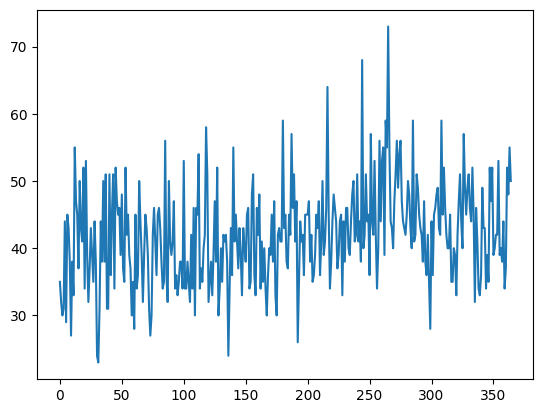

In [9]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('/content/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

In [10]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [11]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [12]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [13]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [14]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [16]:
# load the dataset
series = read_csv('/content/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [25]:
# series.iloc[:].values
print(data[0].shape)

(7,)


>expected=42.0, predicted=45.6
>expected=53.0, predicted=43.4
>expected=39.0, predicted=41.3
>expected=40.0, predicted=38.5
>expected=38.0, predicted=43.0
>expected=44.0, predicted=48.4
>expected=34.0, predicted=42.3
>expected=37.0, predicted=36.6
>expected=52.0, predicted=38.0
>expected=48.0, predicted=41.9
>expected=55.0, predicted=43.7
>expected=50.0, predicted=45.4
MAE: 5.920


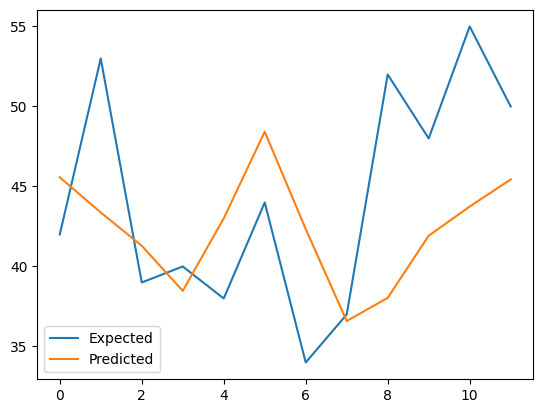

In [ ]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
print(data[0,:])

[35. 32. 30. 31. 44. 29. 45.]


In [26]:
# finalize model and make a prediction for monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values


In [27]:
# load the dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)

In [28]:
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)

In [32]:
print(values[-6:])

[[34]
 [37]
 [52]
 [48]
 [55]
 [50]]


In [29]:
print(train)

[[35. 32. 30. ... 44. 29. 45.]
 [32. 30. 31. ... 29. 45. 43.]
 [30. 31. 44. ... 45. 43. 38.]
 ...
 [40. 38. 44. ... 37. 52. 48.]
 [38. 44. 34. ... 52. 48. 55.]
 [44. 34. 37. ... 48. 55. 50.]]


In [ ]:
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [34 37 52 48 55 50], Predicted: 42.541


In [ ]:
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


from matplotlib import pyplot as plt
_df_0['Births'].plot(kind='hist', bins=20, title='Births')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Births']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Births')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['Births'].plot(kind='line', figsize=(8, 4), title='Births')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='Births', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)